In [1]:
# import
from ultralytics import YOLO

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
from PIL import Image
from io import BytesIO
import io
import matplotlib.patches as patches
import gc
import cv2
# from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg


# xml
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ElementTree, Element, SubElement, tostring
from xml.dom import minidom

%matplotlib inline

### func

In [2]:
def makedirectory(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [3]:
def draw_bboxes_from_xml(image_path, xml_file_path):
    # XML 파일 파싱
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # 이미지 로드
    image = cv2.imread(image_path)
    
    # 데이터프레임에 들어갈 빈 리스트 생성
    xml_data = []
    for object_tag in root.findall('object'):
        # 클래스 정보 추출
        obj_class = object_tag.find('name').text

        # 색상 선택
        if obj_class == 'wheezes' or obj_class == 'wheeze':
            color = (255, 0, 0)  # 파란색
        elif obj_class == 'crackles' or obj_class == 'crackle' or obj_class == 'crckles':
            color = (0, 255, 0)  # 초록색
        elif obj_class == 'normal':
            color = (0, 255, 255)  # 노란색
        else:
            color = (0, 0, 0)  # 미지정 클래스의 경우 검은색

        # bndbox 정보 추출
        bndbox = object_tag.find('bndbox')
        try:
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
        except:
            xmin, ymin, xmax, ymax = 0, 0, 0, 0
        # print(xmin, ymin, xmax ,ymax)
        width = int(root.find("size").find("width").text)
        height = int(root.find("size").find("height").text)
        # print(width, height)
        # xmin = int((xmin/224)*width)
        # ymin = int((ymin/224)*height)
        # xmax = int((xmax/224)*width)
        # ymax = int((ymax/224)*height)
        # print(xmin, ymin, xmax ,ymax)
        
        xml_data.append({'label': obj_class, 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})

        # 이미지에 경계 상자 그리기
        if width > 500: line_width = 5
        else: line_width = 1
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, line_width)
    
    # 경계 상자가 그려진 이미지
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    df = pd.DataFrame(xml_data)

    return img, df


In [10]:
def save_results_img(pred_results, pred_save_path, line_width=1, save=True):
    '''
    pred_save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset6_fix_0408/runs/detect/pred/1_vsLabel_diff/'
    '''
    fpath_ls = []
    for i, result in enumerate(pred_results):
        filename_p = os.path.basename(result.path)
        boxes = result.boxes  # Boxes object for bounding box outputs
        # print('pred boxes: ', len(boxes)) # counting boxes
        masks = result.masks  # Masks object for segmentation masks outputs
        probs = result.probs  # Probs object for classification outputs
        makedirectory(pred_save_path)
        if save:
            result.save(filename=pred_save_path+f'{filename_p}',
                        line_width=line_width)  # save to disk
        else: pass
        fpath_ls.append((result.path, len(boxes)))
        if i % 50 == 0: print('idx: ', i)

    return sorted(fpath_ls)

        

def visualize_result(fpath, b_count, xml_path, pred_save_path):
    '''
    fpath: pred file 전체 경로
    xml_path: 해당 학습에 사용했던 xml 파일이 있는 경로
    b_count: counted bbox in pred 
    '''
    filename = os.path.basename(fpath)
    # ground truth box 구현..
    xml_path = xml_path+filename.replace('.png','.xml')
    img_gt, df = draw_bboxes_from_xml(fpath, xml_path)

    # 저장된 pred 이미지
    img_pred = cv2.cvtColor(cv2.imread(pred_save_path+filename), cv2.COLOR_BGR2RGB)

    # 두 개의 subplot을 생성하여 나란히 표시
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # figsize 조정 가능
    
    # 첫 번째 이미지 (ground truth)를 왼쪽에 표시
    ax1.imshow(img_gt)
    ax1.set_title('Ground Truth')
    ax1.axis('off')  # 축 제거
    
    # 두 번째 이미지 (pred)를 오른쪽에 표시
    ax2.imshow(img_pred)
    ax2.set_title('Pred')
    ax2.axis('off')  # 축 제거

    plt.show()
    print(f'''
{filename}                            counting boxes: {b_count}/{df.index[-1]+1} 

green: crackle     
blue: wheeze
yellow: normal

{df}

------------------------------------------------------------------------------------------------------
    ''')

In [11]:
# change_dataset10 = '1_vsLabel_diff'
# change_dataset11 = '1_vsLabel_same'
# change_dataset20 = '2_filter_x' # == '1_vsLabel_same'
# change_dataset21 = '2_filter_5'
# change_dataset30 = '3_size_224'
# change_dataset31 = '3_size_1280'
# change_dataset40 = '4_iou_05'
# change_dataset41 = '4_iou_07'

In [4]:
# best.pt dir
# pred save source dir
# xml path 

# 1_vsLabel (0: 
best_pt_dir_10 = '/home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/runs/detect/train0402_size224_no_aug6/weights/best.pt'
best_pt_dir_11 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/runs/detect/train0403_size224/weights/best.pt'
source_10 = '/home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/'
source_11 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/'
xml_path_10 = '/home/sogaksa123/AIFFEL_THON/data/dataset4_0331/data_diffax_xml/xml_files/'
xml_path_11 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/with_normal_224/xml_files/'
pred_save_path_10 = '/home/sogaksa123/AIFFEL_THON/data/dataset6_fix_0408/runs/detect/pred/1_vsLabel_diff/'
pred_save_path_11 = '/home/sogaksa123/AIFFEL_THON/data/dataset6_fix_0408/runs/detect/pred/1_vsLabel_same/'

# 2_filter
best_pt_dir_20 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/runs/detect/train0403_size224/weights/best.pt'
best_pt_dir_21 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/runs/detect/train0405_224_with_filtering/weights/best.pt'
source_20 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/'
source_21 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/'
xml_path_20 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/with_normal_224/xml_files/'
xml_path_21 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/filtering5_224/xml_files/'
pred_save_path_20 = '/home/sogaksa123/AIFFEL_THON/data/dataset6_fix_0408/runs/detect/pred/2_filter_x/'
pred_save_path_21 = '/home/sogaksa123/AIFFEL_THON/data/dataset6_fix_0408/runs/detect/pred/2_filter_5/'

# 3_size
best_pt_dir_30 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/runs/detect/train0405_224_with_filtering/weights/best.pt'
best_pt_dir_31 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/runs/detect/train0405_1280_with_filtering/weights/best.pt'
source_30 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/'
source_31 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_1280/Training/data/test/images/'
xml_path_30 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/filtering5_224/xml_files/'
xml_path_31 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/filtering5_1280/xml_files/'
pred_save_path_30 = '/home/sogaksa123/AIFFEL_THON/data/dataset6_fix_0408/runs/detect/pred/3_size_224/'
pred_save_path_31 = '/home/sogaksa123/AIFFEL_THON/data/dataset6_fix_0408/runs/detect/pred/3_size_1280/'

# 4_iou
best_pt_dir_40 = '/home/sogaksa123/AIFFEL_THON/data/dataset6_fix_0408/runs/detect/train0408_224_filter5_iou05/weights/best.pt'
best_pt_dir_41 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/runs/detect/train0405_224_with_filtering/weights/best.pt'
source_40 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/'
source_41 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/'
xml_path_40 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/filtering5_224/xml_files/'
xml_path_41 = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/filtering5_224/xml_files/'
pred_save_path_40 = '/home/sogaksa123/AIFFEL_THON/data/dataset6_fix_0408/runs/detect/pred/4_iou_05/'
pred_save_path_41 = '/home/sogaksa123/AIFFEL_THON/data/dataset6_fix_0408/runs/detect/pred/4_iou_07/'


## inference

|||||||


### 10: 1_vsLabel_diff

In [6]:
# 1_vsLabel_diff
model_10 = YOLO(best_pt_dir_10)  # pretrained YOLOv8n model
# get metric
validation_results_10 = model_10.val(name = 'val/1_vsLabel_diff',
                                     save_json = True,
                                     plots = True) 

Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.0.0+cu117 CUDA:0 (NVIDIA L4, 22517MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_224/Training/data/val/labels.cache... 446 images, 0 backgrounds, 0 corrupt: 100%|██████████| 446/446 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.63it/s]


                   all        446       1468      0.626      0.611      0.642      0.531
              crackles        446        429      0.608      0.499      0.589      0.488
               wheezes        446        318      0.676      0.624      0.685      0.574
                normal        446        721      0.593       0.71      0.651      0.532
Speed: 0.6ms preprocess, 30.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Saving runs/detect/val/1_vsLabel_diff3/predictions.json...
Results saved to runs/detect/val/1_vsLabel_diff3


In [9]:
# Run batched inference on a list of images
pred_results_10 = model_10.predict(source_10, 
                                   name = 'pred/1_vsLabel_diff',
                                   imgsz=640,
                                   line_width = 1)


image 1/446 /home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/101_1b1_Al_sc_Meditron_1.png: 640x640 2 crackless, 1 wheezes, 5 normals, 35.8ms
image 2/446 /home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/102_1b1_Ar_sc_Meditron_0.png: 640x640 5 normals, 40.4ms
image 3/446 /home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/103_2b2_Ar_mc_LittC2SE_1.png: 640x640 3 normals, 41.7ms
image 4/446 /home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/104_1b1_Lr_sc_Litt3200_0.png: 640x640 1 wheezes, 5 normals, 43.3ms
image 5/446 /home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/104_1b1_Lr_sc_Litt3200_2.png: 640x640 1 wheezes, 1 normal, 42.2ms
image 6/446 /home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_22

In [11]:
# save pred img
fpath_ls_10 = save_results_img(pred_results_10, pred_save_path_10, save=False) # (fpath, b_count) tuple list

idx:  0
idx:  50
idx:  100
idx:  150
idx:  200
idx:  250
idx:  300
idx:  350
idx:  400


#### visualize

In [75]:
f_ls21 = []
b_ls21 = []
for f21, b21 in fpath_ls_21:
    f_ls21.append(f21) # pred file 전체 경로
    b_ls21.append(b21) # f_ls랑 인덱스 맞춘 박스 개수 

f_ls20 = []
b_ls20 = []
for f20, b20 in fpath_ls_20:
    f_ls20.append(f20) # pred file 전체 경로
    b_ls20.append(b20) # f_ls랑 인덱스 맞춘 박스 개수 

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


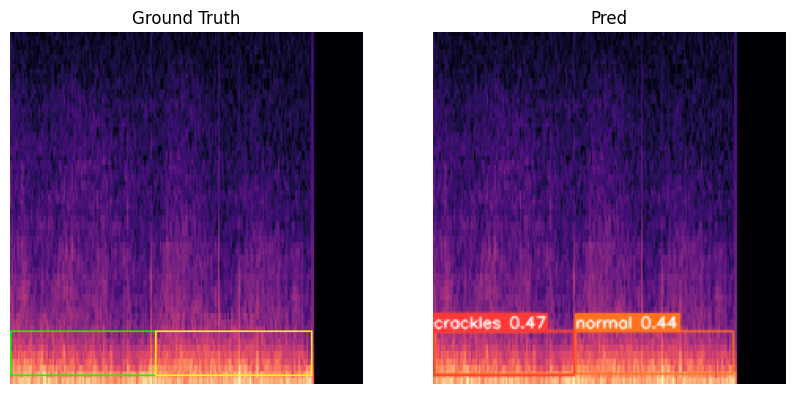


145_2b2_Ar_mc_AKGC417L_2.png                            counting boxes: 3/2 

green: crackle     
blue: wheeze
yellow: normal

      label  xmin  ymin  xmax  ymax
0  crackles     0   190    92   218
1    normal    92   190   191   218

------------------------------------------------------------------------------------------------------
    


In [50]:
#### pred visualizing
idx = 120

f_ls = []
b_ls = []
for f, b in fpath_ls_10:
    f_ls.append(f) # pred file 전체 경로
    b_ls.append(b) # f_ls랑 인덱스 맞춘 박스 개수 

visualize_result(f_ls[idx], b_ls[idx], xml_path_10, pred_save_path_10)

### 11: 1_vsLabel_same

In [13]:
# 1_vsLabel_same
model_11 = YOLO(best_pt_dir_11)  # pretrained YOLOv8n model
# get metric
validation_results_11 = model_11.val(name='val/1_vsLabel_same',
                                     save_json=True,
                                     plots=True) 

Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.0.0+cu117 CUDA:0 (NVIDIA L4, 22517MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/val/labels.cache... 446 images, 0 backgrounds, 0 corrupt: 100%|██████████| 446/446 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.58it/s]


                   all        446       1468       0.64      0.604      0.664      0.565
              crackles        446        429      0.601      0.562      0.618      0.534
               wheezes        446        318      0.669      0.575      0.674      0.581
                normal        446        721       0.65      0.674      0.699      0.581
Speed: 0.6ms preprocess, 31.7ms inference, 0.0ms loss, 2.2ms postprocess per image
Saving runs/detect/val/1_vsLabel_same3/predictions.json...
Results saved to runs/detect/val/1_vsLabel_same3


In [14]:
# Run batched inference on a list of images
pred_results_11 = model_11.predict(source_11, 
                                   name='pred/1_vsLabel_same',
                                   imgsz=640,
                                   line_width=1)


image 1/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/101_1b1_Al_sc_Meditron_1.png: 640x640 5 normals, 40.5ms
image 2/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/102_1b1_Ar_sc_Meditron_0.png: 640x640 5 normals, 43.9ms
image 3/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/103_2b2_Ar_mc_LittC2SE_1.png: 640x640 3 normals, 42.3ms
image 4/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/104_1b1_Lr_sc_Litt3200_0.png: 640x640 7 normals, 43.2ms
image 5/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/104_1b1_Lr_sc_Litt3200_2.png: 640x640 1 wheezes, 1 normal, 42.9ms
image 6/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/106_2b1

In [15]:
# save pred img
fpath_ls_11 = save_results_img(pred_results_11, pred_save_path_11, save=False)

idx:  0
idx:  50
idx:  100
idx:  150
idx:  200
idx:  250
idx:  300
idx:  350
idx:  400


#### visualize

In [76]:
# pred visualizing

f_ls = []
b_ls = []
for f, b in fpath_ls_11:
    f_ls.append(f) # pred file 전체 경로
    b_ls.append(b) # f_ls랑 인덱스 맞춘 박스 개수 

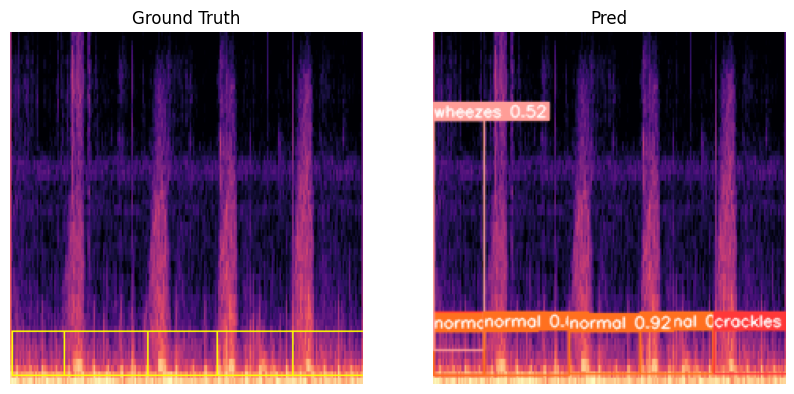


225_1b1_Pl_sc_Meditron_0.png                            counting boxes: 5/5 

green: crackle     
blue: wheeze
yellow: normal

    label  xmin  ymin  xmax  ymax
0  normal     1   190    34   218
1  normal    34   190    87   218
2  normal    87   190   131   218
3  normal   131   190   179   218
4  normal   179   190   224   218

------------------------------------------------------------------------------------------------------
    


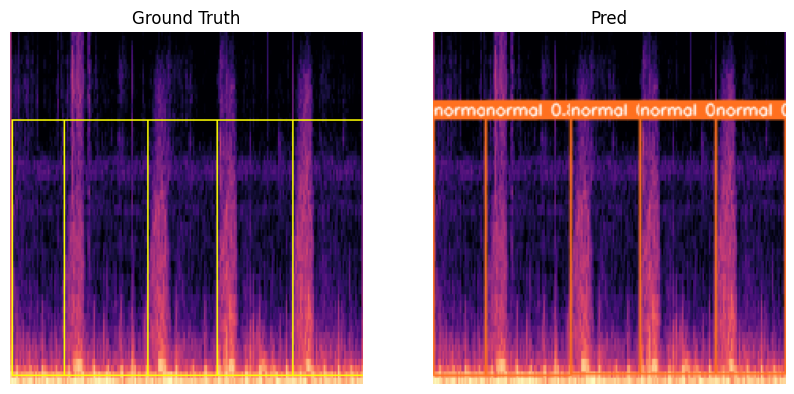


225_1b1_Pl_sc_Meditron_0.png                            counting boxes: 5/5 

green: crackle     
blue: wheeze
yellow: normal

    label  xmin  ymin  xmax  ymax
0  normal     1    56    34   218
1  normal    34    56    87   218
2  normal    87    56   131   218
3  normal   131    56   179   218
4  normal   179    56   224   218

------------------------------------------------------------------------------------------------------
    


In [67]:
idx = 445

visualize_result(f_ls[idx], b_ls[idx], xml_path_10, pred_save_path_10)
visualize_result(f_ls[idx], b_ls[idx], xml_path_11, pred_save_path_11)

### 20: 2_filter_x

In [68]:
# 2_filter_x
model_20 = YOLO(best_pt_dir_20)  # pretrained YOLOv8n model
# get metric
validation_results_20 = model_20.val(name='val/2_filter_x',
                                     save_json=True,
                                     plots=True) 

Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.0.0+cu117 CUDA:0 (NVIDIA L4, 22517MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/val/labels.cache... 446 images, 0 backgrounds, 0 corrupt: 100%|██████████| 446/446 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]


                   all        446       1468       0.64      0.604      0.664      0.565
              crackles        446        429      0.601      0.562      0.618      0.534
               wheezes        446        318      0.669      0.575      0.674      0.581
                normal        446        721       0.65      0.674      0.699      0.581
Speed: 0.7ms preprocess, 31.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Saving runs/detect/val/2_filter_x3/predictions.json...
Results saved to runs/detect/val/2_filter_x3


In [69]:
# pred
pred_results_20 = model_20.predict(source_20, 
                                   name='pred/2_filter_x',
                                   imgsz=640,
                                   line_width=1)


image 1/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/101_1b1_Al_sc_Meditron_1.png: 640x640 5 normals, 41.3ms
image 2/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/102_1b1_Ar_sc_Meditron_0.png: 640x640 5 normals, 43.4ms
image 3/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/103_2b2_Ar_mc_LittC2SE_1.png: 640x640 3 normals, 43.3ms
image 4/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/104_1b1_Lr_sc_Litt3200_0.png: 640x640 7 normals, 41.8ms
image 5/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/104_1b1_Lr_sc_Litt3200_2.png: 640x640 1 wheezes, 1 normal, 43.4ms
image 6/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/106_2b1

In [70]:
# save pred img
fpath_ls_20 = save_results_img(pred_results_20, pred_save_path_20, save=False)

idx:  0
idx:  50
idx:  100
idx:  150
idx:  200
idx:  250
idx:  300
idx:  350
idx:  400


#### visualize

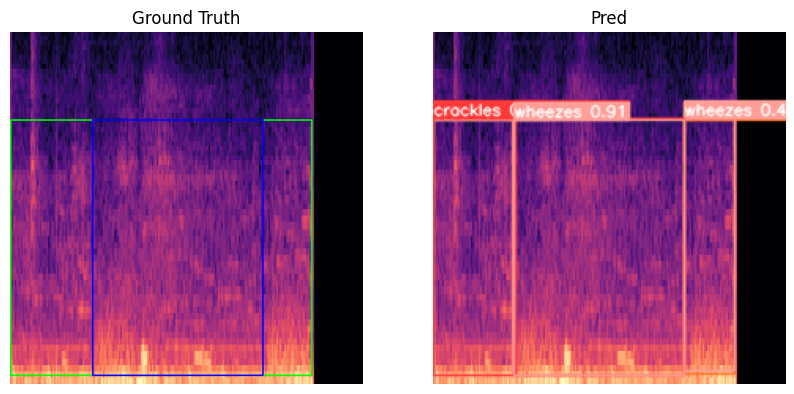


114_1b4_Pr_mc_AKGC417L_2.png                            counting boxes: 6/4 

green: crackle     
blue: wheeze
yellow: normal

      label  xmin  ymin  xmax  ymax
0  crackles     0    56    52   218
1  crackles    52    56   160   218
2  crackles   160    56   191   218
3   wheezes    52    56   160   218

------------------------------------------------------------------------------------------------------
    


In [74]:
# pred visualizing
idx = 36


f_ls = []
b_ls = []
for f, b in fpath_ls_20:
    f_ls.append(f) # pred file 전체 경로
    b_ls.append(b) # f_ls랑 인덱스 맞춘 박스 개수 

visualize_result(f_ls[idx], b_ls[idx], xml_path_20, pred_save_path_20)

### 21: 2_filter_5

In [71]:
# 2_filter_5
model_21 = YOLO(best_pt_dir_21)  # pretrained YOLOv8n model
# get metric
validation_results_21 = model_21.val(name = 'val/2_filter_5',
                                     save_json = True,
                                     plots = True) 

Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.0.0+cu117 CUDA:0 (NVIDIA L4, 22517MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/val/labels.cache... 446 images, 0 backgrounds, 0 corrupt: 100%|██████████| 446/446 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.56it/s]


                   all        446       1468      0.603      0.654      0.664      0.559
              crackles        446        429      0.523      0.643      0.624      0.537
               wheezes        446        318      0.668      0.604      0.673      0.569
                normal        446        721      0.618      0.716      0.696      0.571
Speed: 0.6ms preprocess, 32.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Saving runs/detect/val/2_filter_53/predictions.json...
Results saved to runs/detect/val/2_filter_53


In [72]:
# pred
pred_results_21 = model_21.predict(source_21, 
                                   name='pred/2_filter_5',
                                   imgsz=640,
                                   line_width=1)


image 1/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/101_1b1_Al_sc_Meditron_1.png: 640x640 6 normals, 41.5ms
image 2/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/102_1b1_Ar_sc_Meditron_0.png: 640x640 5 normals, 43.3ms
image 3/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/103_2b2_Ar_mc_LittC2SE_1.png: 640x640 1 crackles, 1 wheezes, 1 normal, 42.6ms
image 4/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/104_1b1_Lr_sc_Litt3200_0.png: 640x640 2 wheezess, 4 normals, 43.2ms
image 5/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/104_1b1_Lr_sc_Litt3200_2.png: 640x640 1 normal, 42.7ms
image 6/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filte

In [73]:
# save pred img
fpath_ls_21 = save_results_img(pred_results_21, pred_save_path_21, save=False)

idx:  0
idx:  50
idx:  100
idx:  150
idx:  200
idx:  250
idx:  300
idx:  350
idx:  400


#### visualize

In [90]:
f_ls21 = []
b_ls21 = []
for f21, b21 in fpath_ls_21:
    f_ls21.append(f21) # pred file 전체 경로
    b_ls21.append(b21) # f_ls랑 인덱스 맞춘 박스 개수 

f_ls20 = []
b_ls20 = []
for f20, b20 in fpath_ls_20:
    f_ls20.append(f20) # pred file 전체 경로
    b_ls20.append(b20) # f_ls랑 인덱스 맞춘 박스 개수 

In [110]:
f_ls20[0]
filename = '176_1b3_Al_mc_AKGC417L_2.png'
idx = f_ls20.index(f'/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/{filename}')
idx

290

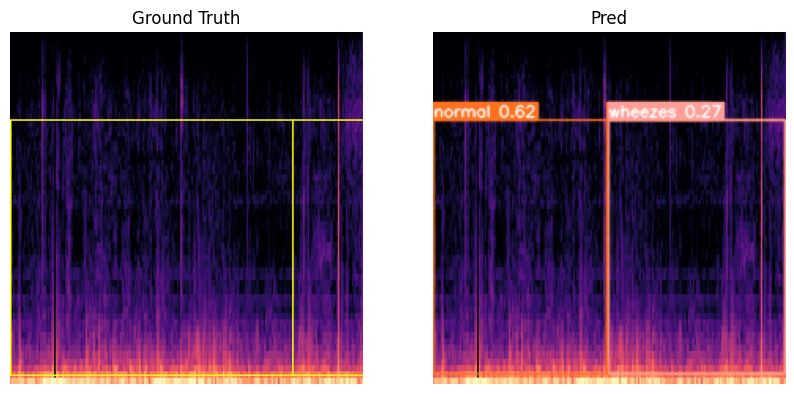


110_1p1_Pr_sc_Meditron_5.png                            counting boxes: 3/2 

green: crackle     
blue: wheeze
yellow: normal

    label  xmin  ymin  xmax  ymax
0  normal     0    56   179   218
1  normal   179    56   224   218

------------------------------------------------------------------------------------------------------
    


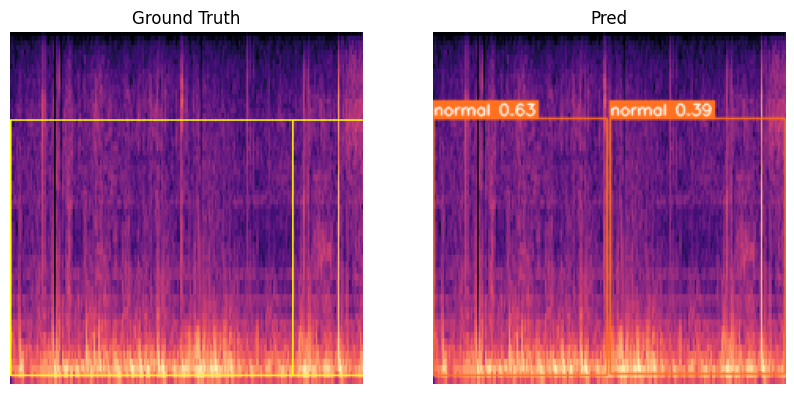


110_1p1_Pr_sc_Meditron_5.png                            counting boxes: 2/2 

green: crackle     
blue: wheeze
yellow: normal

    label  xmin  ymin  xmax  ymax
0  normal     0    56   179   218
1  normal   179    56   224   218

------------------------------------------------------------------------------------------------------
    


In [113]:
# pred visualizing

idx = 27

visualize_result(f_ls20[idx], b_ls20[idx], xml_path_20, pred_save_path_20)
visualize_result(f_ls21[idx], b_ls21[idx], xml_path_21, pred_save_path_21)

### 30: 3_size_224

In [66]:
# 3_size_224
model_30 = YOLO(best_pt_dir_30)  # pretrained YOLOv8n model
# get metric
validation_results_30 = model_30.val(name='val/3_size_224',
                                     save_json=True,
                                     plots=True) 

Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.0.0+cu117 CUDA:0 (NVIDIA L4, 22478MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/val/labels.cache... 446 images, 0 backgrounds, 0 corrupt: 100%|██████████| 446/446 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:48<00:00,  1.74s/it]


                   all        446       1468      0.603      0.654      0.664      0.559
              crackles        446        429      0.523      0.643      0.624      0.537
               wheezes        446        318      0.668      0.604      0.673      0.569
                normal        446        721      0.618      0.716      0.696      0.571
Speed: 1.0ms preprocess, 64.4ms inference, 0.0ms loss, 9.5ms postprocess per image
Saving runs/detect/val/3_size_2242/predictions.json...
Results saved to runs/detect/val/3_size_2242


In [67]:
# pred
pred_results_30 = model_30.predict(source_30, 
                                   name='pred/3_size_224',
                                   imgsz=640,
                                   line_width=1)


image 1/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/101_1b1_Al_sc_Meditron_1.png: 640x640 6 normals, 107.5ms
image 2/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/102_1b1_Ar_sc_Meditron_0.png: 640x640 5 normals, 59.2ms
image 3/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/103_2b2_Ar_mc_LittC2SE_1.png: 640x640 1 crackles, 1 wheezes, 1 normal, 47.8ms
image 4/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/104_1b1_Lr_sc_Litt3200_0.png: 640x640 2 wheezess, 4 normals, 93.3ms
image 5/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/104_1b1_Lr_sc_Litt3200_2.png: 640x640 1 normal, 105.3ms
image 6/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/fil

In [68]:
# save pred img
fpath_ls_30 = save_results_img(pred_results_30, pred_save_path_30, save=False)

idx:  0
idx:  50
idx:  100
idx:  150
idx:  200
idx:  250
idx:  300
idx:  350
idx:  400


#### visualize

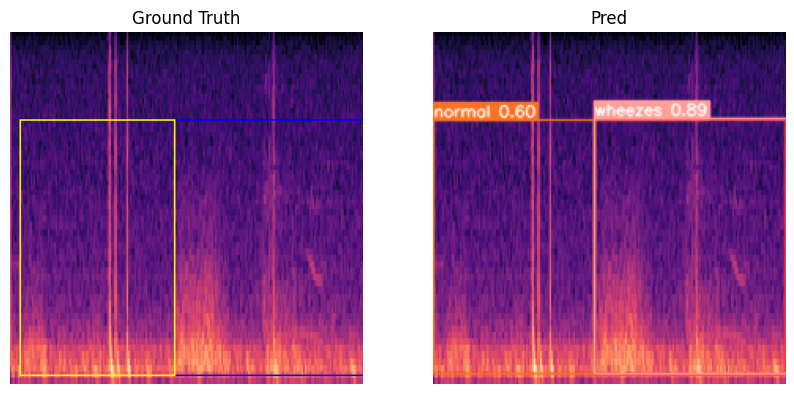


122_2b1_Al_mc_LittC2SE_0.png                            counting boxes: 3/2 

green: crackle     
blue: wheeze
yellow: normal

     label  xmin  ymin  xmax  ymax
0  wheezes   104    56   224   218
1   normal     6    56   104   218

------------------------------------------------------------------------------------------------------
    


In [97]:
# pred visualizing
idx = 52

f_ls = []
b_ls = []
for f, b in fpath_ls_30:
    f_ls.append(f) # pred file 전체 경로
    b_ls.append(b) # f_ls랑 인덱스 맞춘 박스 개수 

visualize_result(f_ls[idx], b_ls[idx], xml_path_30, pred_save_path_30)

### 31: 3_size_1280

In [69]:
# 3_size_2180
model_31 = YOLO(best_pt_dir_31)  # pretrained YOLOv8n model
# get metric
validation_results_31 = model_31.val(name='val/3_size_2180',
                                     save_json=True,
                                     plots=True) 

Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.0.0+cu117 CUDA:0 (NVIDIA L4, 22478MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_1280/Training/data/val/labels.cache... 446 images, 0 backgrounds, 0 corrupt: 100%|██████████| 446/446 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:36<00:00,  1.29s/it]


                   all        446       1468      0.643      0.682      0.701      0.603
              crackles        446        429      0.611      0.648      0.674      0.588
               wheezes        446        318      0.663      0.635      0.704      0.612
                normal        446        721      0.654      0.763      0.724      0.608
Speed: 0.7ms preprocess, 37.6ms inference, 0.0ms loss, 9.2ms postprocess per image
Saving runs/detect/val/3_size_21802/predictions.json...
Results saved to runs/detect/val/3_size_21802


In [70]:
# pred
pred_results_31 = model_31.predict(source_31, 
                                   name='pred/3_size_2180',
                                   imgsz=640,
                                   line_width=6)


image 1/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_1280/Training/data/test/images/101_1b1_Al_sc_Meditron_1.png: 384x640 5 normals, 93.3ms
image 2/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_1280/Training/data/test/images/102_1b1_Ar_sc_Meditron_0.png: 384x640 6 normals, 93.2ms
image 3/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_1280/Training/data/test/images/103_2b2_Ar_mc_LittC2SE_1.png: 384x640 2 normals, 89.4ms
image 4/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_1280/Training/data/test/images/104_1b1_Lr_sc_Litt3200_0.png: 384x640 3 wheezess, 4 normals, 89.2ms
image 5/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_1280/Training/data/test/images/104_1b1_Lr_sc_Litt3200_2.png: 384x640 1 wheezes, 1 normal, 84.0ms
image 6/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_12

In [71]:
# save pred img
fpath_ls_31 = save_results_img(pred_results_31, pred_save_path_31, line_width=6, save=False) # 1280이라 6으로 설정

idx:  0
idx:  50
idx:  100
idx:  150
idx:  200
idx:  250
idx:  300
idx:  350
idx:  400


#### visualize

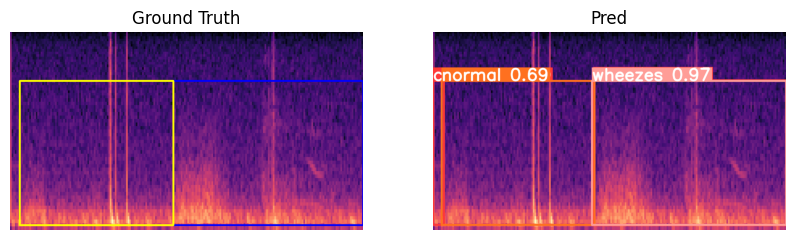


122_2b1_Al_mc_LittC2SE_0.png                            counting boxes: 4/2 

green: crackle     
blue: wheeze
yellow: normal

     label  xmin  ymin  xmax  ymax
0  wheezes   592   180  1280   702
1   normal    35   180   592   702

------------------------------------------------------------------------------------------------------
    


In [98]:
# pred visualizing
idx = 52

f_ls = []
b_ls = []
for f, b in fpath_ls_31:
    f_ls.append(f) # pred file 전체 경로
    b_ls.append(b) # f_ls랑 인덱스 맞춘 박스 개수 

visualize_result(f_ls[idx], b_ls[idx], xml_path_31, pred_save_path_31)

### 40: 4_iou_05

In [114]:
# 4_iou_05
model_40 = YOLO(best_pt_dir_40)  # pretrained YOLOv8n model
# get metric
validation_results_40 = model_40.val(name='val/4_iou_05',
                                     save_json=True,
                                     plots=True) 

Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.0.0+cu117 CUDA:0 (NVIDIA L4, 22517MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/val/labels.cache... 446 images, 0 backgrounds, 0 corrupt: 100%|██████████| 446/446 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.60it/s]


                   all        446       1468      0.605       0.66      0.663      0.561
              crackles        446        429      0.534      0.688      0.641      0.543
               wheezes        446        318       0.64      0.594       0.67      0.575
                normal        446        721      0.641      0.699      0.679      0.566
Speed: 0.6ms preprocess, 31.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Saving runs/detect/val/4_iou_052/predictions.json...
Results saved to runs/detect/val/4_iou_052


In [115]:
# pred
pred_results_40 = model_40.predict(source_40, 
                                   name='pred/4_iou_05',
                                   imgsz=640,
                                   line_width=1)


image 1/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/101_1b1_Al_sc_Meditron_1.png: 640x640 1 crackles, 5 normals, 41.0ms
image 2/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/102_1b1_Ar_sc_Meditron_0.png: 640x640 5 normals, 42.6ms
image 3/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/103_2b2_Ar_mc_LittC2SE_1.png: 640x640 1 normal, 41.6ms
image 4/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/104_1b1_Lr_sc_Litt3200_0.png: 640x640 1 wheezes, 4 normals, 43.3ms
image 5/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/104_1b1_Lr_sc_Litt3200_2.png: 640x640 1 normal, 42.5ms
image 6/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Trai

In [116]:
# save pred img
fpath_ls_40 = save_results_img(pred_results_40, pred_save_path_40)

idx:  0
idx:  50
idx:  100
idx:  150
idx:  200
idx:  250
idx:  300
idx:  350
idx:  400


#### visualize

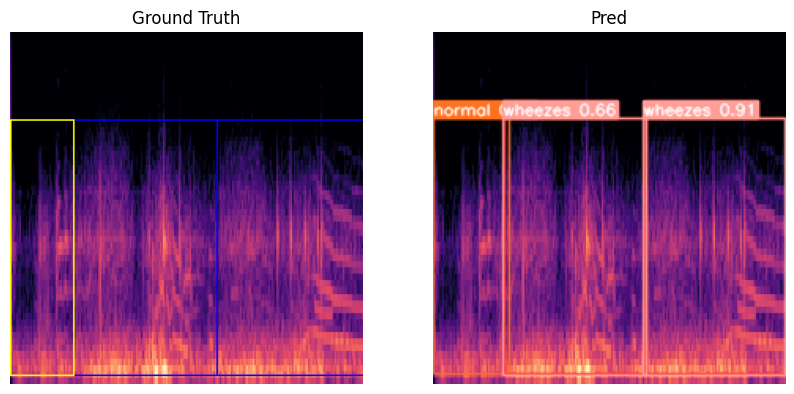


112_1p1_Pl_sc_Litt3200_1.png                            counting boxes: 5/5 

green: crackle     
blue: wheeze
yellow: normal

      label  xmin  ymin  xmax  ymax
0  crackles    40    56   131   218
1  crackles   131    56   224   218
2   wheezes    40    56   131   218
3   wheezes   131    56   224   218
4    normal     0    56    40   218

------------------------------------------------------------------------------------------------------
    


In [113]:
# pred visualizing
idx = 31

f_ls = []
b_ls = []
for f, b in fpath_ls_40:
    f_ls.append(f) # pred file 전체 경로
    b_ls.append(b) # f_ls랑 인덱스 맞춘 박스 개수 

visualize_result(f_ls[idx], b_ls[idx], xml_path_40, pred_save_path_40)

### 41: 4_iou_07

In [117]:
# 4_iou_07
model_41 = YOLO(best_pt_dir_41)  # pretrained YOLOv8n model
# get metric
validation_results_41 = model_41.val(name='val/4_iou_07',
                                     save_json=True,
                                     plots=True)  

Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.0.0+cu117 CUDA:0 (NVIDIA L4, 22517MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/val/labels.cache... 446 images, 0 backgrounds, 0 corrupt: 100%|██████████| 446/446 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:17<00:00,  1.57it/s]


                   all        446       1468      0.603      0.654      0.664      0.559
              crackles        446        429      0.523      0.643      0.624      0.537
               wheezes        446        318      0.668      0.604      0.673      0.569
                normal        446        721      0.618      0.716      0.696      0.571
Speed: 0.6ms preprocess, 32.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Saving runs/detect/val/4_iou_073/predictions.json...
Results saved to runs/detect/val/4_iou_073


In [118]:
# pred
pred_results_41 = model_41.predict(source_41, 
                                   name='pred/4_iou_07',
                                   imgsz=640,
                                   line_width=1)


image 1/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/101_1b1_Al_sc_Meditron_1.png: 640x640 6 normals, 41.7ms
image 2/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/102_1b1_Ar_sc_Meditron_0.png: 640x640 5 normals, 44.8ms
image 3/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/103_2b2_Ar_mc_LittC2SE_1.png: 640x640 1 crackles, 1 wheezes, 1 normal, 42.9ms
image 4/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/104_1b1_Lr_sc_Litt3200_0.png: 640x640 2 wheezess, 4 normals, 44.3ms
image 5/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/104_1b1_Lr_sc_Litt3200_2.png: 640x640 1 normal, 43.2ms
image 6/446 /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filte

In [119]:
# save pred img
fpath_ls_41 = save_results_img(pred_results_41, pred_save_path_41, save=False)

idx:  0
idx:  50
idx:  100
idx:  150
idx:  200
idx:  250
idx:  300
idx:  350
idx:  400


#### visualize

In [ ]:
f_ls40 = []
b_ls40 = []
for f40, b40 in fpath_ls_40:
    f40_ls.append(f40) # pred file 전체 경로
    b40_ls.append(b40) # f_ls랑 인덱스 맞춘 박스 개수 

f_ls41 = []
b_ls41 = []
for f41, b41 in fpath_ls_41:
    f_ls41.append(f41) # pred file 전체 경로
    b_ls41.append(b41) # f_ls랑 인덱스 맞춘 박스 개수 

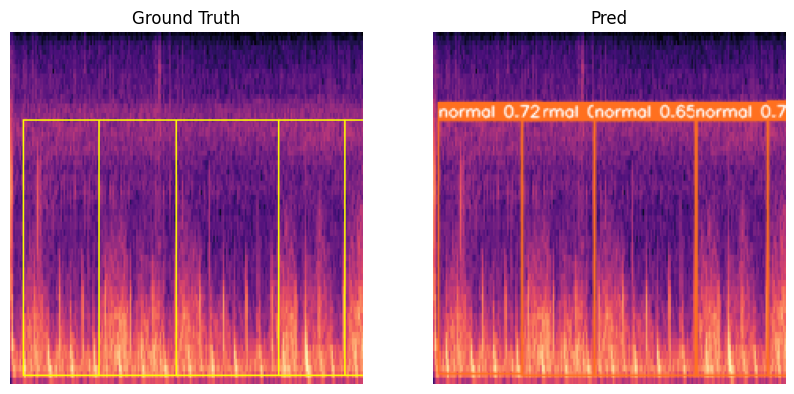


102_1b1_Ar_sc_Meditron_0.png                            counting boxes: 5/5 

green: crackle     
blue: wheeze
yellow: normal

    label  xmin  ymin  xmax  ymax
0  normal     8    56    56   218
1  normal    56    56   105   218
2  normal   105    56   170   218
3  normal   170    56   212   218
4  normal   212    56   224   218

------------------------------------------------------------------------------------------------------
    


In [112]:
# pred visualizing
idx = 1



visualize_result(f_ls[idx], b_ls[idx], xml_path_41, pred_save_path_41)

### 확인

In [45]:
print(len(os.listdir(pred_save_path_10)))
print(len(os.listdir(pred_save_path_11)))
print(len(os.listdir(pred_save_path_20)))
print(len(os.listdir(pred_save_path_21)))
print(len(os.listdir(pred_save_path_30)))
print(len(os.listdir(pred_save_path_31)))
# print(len(os.listdir(pred_save_path_40)))
print(len(os.listdir(pred_save_path_41)))

447
446
446
446
446
446
446


## trash

In [119]:
# source = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/test/images/'
# save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/test/result/'


In [120]:
# # # Load a model
# # # Run batched inference on a list of images
# results = model.predict(source, 
#                         save=True, 
#                         imgsz=640, 
#                         iou=0.75)
#                       # classes = [2])


In [ ]:
# # # Process results list
# for result in results:
#     filename_p = os.path.basename(result.path)
#     save_filename = os.path.join(save_path, filename_p)
#     boxes = result.boxes  # Boxes object for bounding box outputs
#     masks = result.masks  # Masks object for segmentation masks outputs
#     keypoints = result.keypoints  # Keypoints object for pose outputs
#     probs = result.probs  # Probs object for classification outputs
#     result.show(line_width=1)  # display to screen
#     result.save(filename=save_filename)  # save to disk

### 테스트 결과 시각화

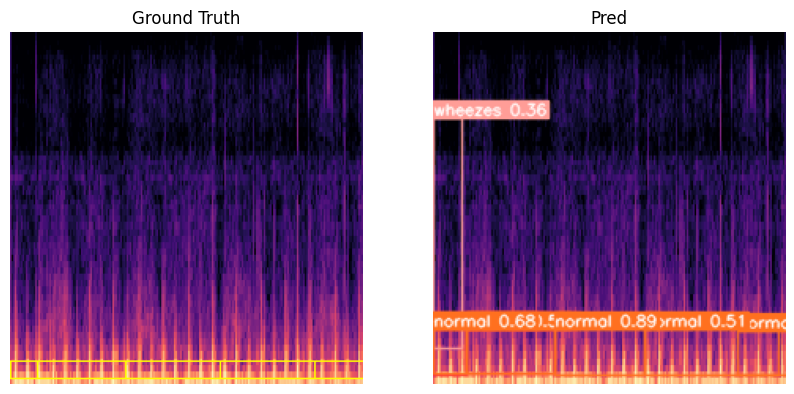

101_1b1_Al_sc_Meditron_1.png

green: crackle
blue: wheeze
yellow: normal

    label  xmin  ymin  xmax  ymax
0  normal     0   220    17   209
1  normal    17   220    73   209
2  normal    73   220   133   209
3  normal   133   220   193   209
4  normal   193   220   224   209

------------------------------------------------------------------------------------------------------
    


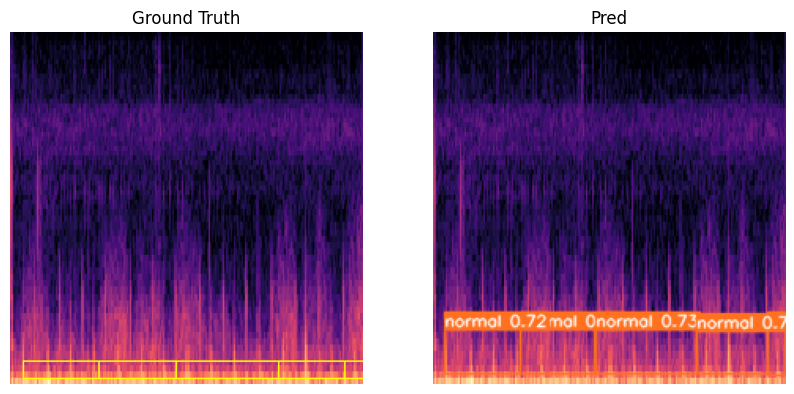

102_1b1_Ar_sc_Meditron_0.png

green: crackle
blue: wheeze
yellow: normal

    label  xmin  ymin  xmax  ymax
0  normal     8   220    56   209
1  normal    56   220   105   209
2  normal   105   220   170   209
3  normal   170   220   212   209
4  normal   212   220   224   209

------------------------------------------------------------------------------------------------------
    


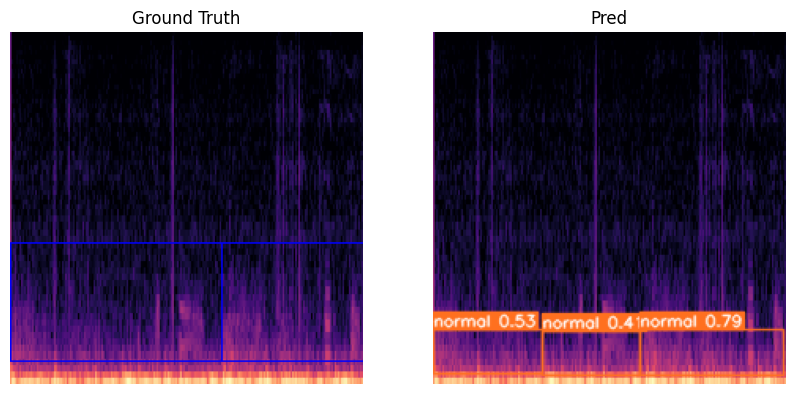

103_2b2_Ar_mc_LittC2SE_1.png

green: crackle
blue: wheeze
yellow: normal

     label  xmin  ymin  xmax  ymax
0  wheezes     0   209   134   134
1  wheezes   134   209   224   134

------------------------------------------------------------------------------------------------------
    


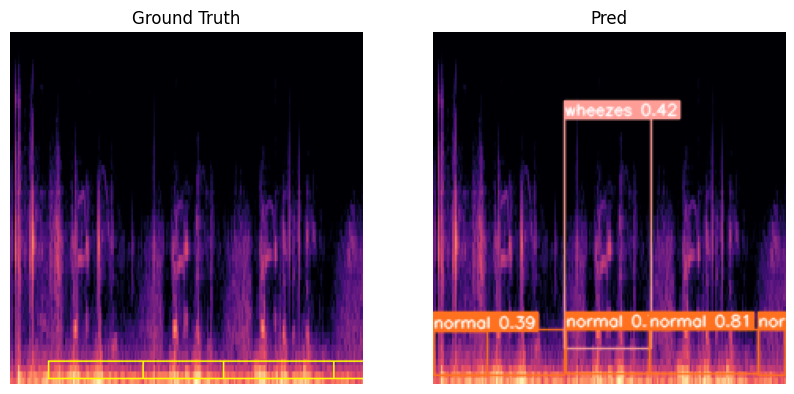

104_1b1_Lr_sc_Litt3200_0.png

green: crackle
blue: wheeze
yellow: normal

    label  xmin  ymin  xmax  ymax
0  normal    24   220    84   209
1  normal    84   220   135   209
2  normal   135   220   205   209
3  normal   205   220   224   209

------------------------------------------------------------------------------------------------------
    


In [99]:
##### 0409

# # Process results list
# for i, result in enumerate(pred_results10):
    
#     filename_p = os.path.basename(result.path)
#     # print(result.path)
#     boxes = result.boxes  # Boxes object for bounding box outputs
#     # print(type(boxes))
#     # print(len(boxes))
#     # break
#     masks = result.masks  # Masks object for segmentation masks outputs
#     # keypoints = result.keypoints  # Keypoints object for pose outputs
#     probs = result.probs  # Probs object for classification outputs
#     # result.show(line_width=1)  # display to screen
#     save_path = '/home/sogaksa123/AIFFEL_THON/data/dataset6_fix_0408/runs/detect/pred/1_vsLabel_diff/'
#     makedirectory(save_path)
#     result.save(filename=save_path+f'{filename_p}',
#                 line_width=1)  # save to disk

#     # ground truth box 구현..
#     xml_path = xml_path10+filename_p.replace('.png','.xml')
#     img_gt, df = draw_bboxes_from_xml(result.path, xml_path)

#     # 저장된 pred 이미지
#     saved_pred = save_path+filename_p
#     img_pred = cv2.cvtColor(cv2.imread(saved_pred), cv2.COLOR_BGR2RGB)

#     # 두 개의 subplot을 생성하여 나란히 표시
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # figsize 조정 가능
    
#     # 첫 번째 이미지 (ground truth)를 왼쪽에 표시
#     ax1.imshow(img_gt)
#     ax1.set_title('Ground Truth')
#     ax1.axis('off')  # 축 제거
    
#     # 두 번째 이미지 (pred)를 오른쪽에 표시
#     ax2.imshow(img_pred)
#     ax2.set_title('Pred')
#     ax2.axis('off')  # 축 제거

#     plt.show()
#     print(filename_p)
#     print(f'''
# green: crackle
# blue: wheeze
# yellow: normal

# {df}

# ------------------------------------------------------------------------------------------------------
#     ''')
#     # # xml 확인
#     # with open(xml_path) as f:
#     #     contents = f.read()
#     #     print(contents)
#     if i == 3: break

# 추가 시각화


In [120]:
# Bbox 

f_ls10 = []
b_ls10 = []
for f10, b10 in fpath_ls_10:
    f_ls10.append(f10) # pred file 전체 경로
    b_ls10.append(b10) # f_ls랑 인덱스 맞춘 박스 개수 

f_ls11 = []
b_ls11 = []
for f11, b11 in fpath_ls_11:
    f_ls11.append(f11) # pred file 전체 경로
    b_ls11.append(b11) # f_ls랑 인덱스 맞춘 박스 개수 

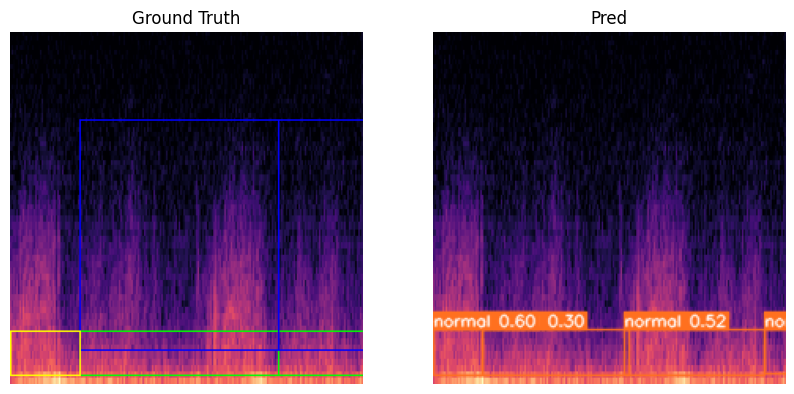


146_2b2_Pl_mc_AKGC417L_1.png                            counting boxes: 4/5 

green: crackle     
blue: wheeze
yellow: normal

      label  xmin  ymin  xmax  ymax
0  crackles    44   190   170   218
1  crackles   170   190   224   218
2   wheezes    44    56   170   202
3   wheezes   170    56   224   202
4    normal     0   190    44   218

------------------------------------------------------------------------------------------------------
    


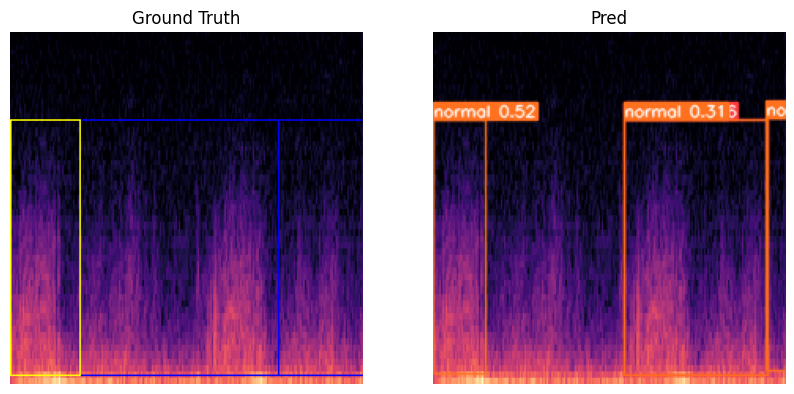


146_2b2_Pl_mc_AKGC417L_1.png                            counting boxes: 4/5 

green: crackle     
blue: wheeze
yellow: normal

      label  xmin  ymin  xmax  ymax
0  crackles    44    56   170   218
1  crackles   170    56   224   218
2   wheezes    44    56   170   218
3   wheezes   170    56   224   218
4    normal     0    56    44   218

------------------------------------------------------------------------------------------------------
    


In [133]:
idx = 123

visualize_result(f_ls10[idx], b_ls10[idx], xml_path_10, pred_save_path_10)
visualize_result(f_ls11[idx], b_ls11[idx], xml_path_11, pred_save_path_11)